***1-Dataset Construction — Automated Traffic Capture and CSV Extraction***

All code related to the dataset collection and processing described in this section is available in the file **capture.py**.
To build the dataset, we implemented a Python-based automated pipeline that combines active website access with passive traffic capture. We targeted 10 popular news websites and visited each one 10 times. For every visit, we used Python’s requests library to initiate an HTTPS connection, while concurrently running tshark on a selected network interface to passively capture only encrypted HTTPS (TCP 443) and DNS (UDP 53) packets. The capture lasted 15 seconds per session.
The captured traffic was saved into .pcap files, which were then automatically converted into two .csv files using tshark's field extraction mode: a detailed capture with protocol and length fields, and a timestamp-only version for possible time-series analysis. Each packet was labeled with the website name and run_id, making the dataset suitable for supervised classification. The final outputs are two global CSVs (da_abc.csv and t_abc.csv) that aggregate all captured runs.

Note: All data capture and processing were performed locally on a physical device, not in cloud or Colab environments. This ensured realistic network interface access and authentic capture of low-level packet data.

***2-Biflow Feature Extraction from Captured Traffic***

To build a feature-rich dataset from the captured traffic, we computed biflow-level statistical features for each website visit. We first grouped the packet-level data by (website, run_id), then split the traffic into uplink (client → server) and downlink (server → client) directions based on port 443.

For both uplink and downlink flows, we extracted the following features:

Packet-based: total number of packets, total bytes transferred, and the min, max, mean, and standard deviation of packet sizes.

Time-based: inter-arrival times (IATs) between packets, including their min, max, mean, and standard deviation.

All extracted features were collected into a Python dictionary per session, and combined into a structured DataFrame using pandas. Each row in this DataFrame represents one labeled session, while each column corresponds to a specific biflow feature. The resulting dataset — biflow_features.csv — is suitable for use in classification models and forms the core input for our fingerprinting experiments.

***2-1-Upload CSV file***

In [1]:
from google.colab import files
uploaded = files.upload()


Saving da_abc.csv to da_abc.csv


***2-2 & 3 -Extract biflow features (uplink/downlink),Create DataFrame with ground truth***

In [2]:
import pandas as pd
import numpy as np

# 1. Read the aggregated CSV containing all packets from all runs/websites
df = pd.read_csv("da_abc.csv")  # Replace with the actual filename if different

# 2. Convert columns to numeric where needed
#    (Sometimes TShark outputs them as strings.)
df['tcp.srcport'] = pd.to_numeric(df['tcp.srcport'], errors='coerce')
df['tcp.dstport'] = pd.to_numeric(df['tcp.dstport'], errors='coerce')
df['frame.len'] = pd.to_numeric(df['frame.len'], errors='coerce')
df['frame.time_epoch'] = pd.to_numeric(df['frame.time_epoch'], errors='coerce')

# 3. Prepare a DataFrame to hold features (one row per capture)
rows = []

# 4. Group by website and run_id
grouped = df.groupby(['website', 'run_id'])

for (website, run_id), group in grouped:
    # --- Separate Uplink vs Downlink ---
    # Uplink: client -> server (tcp.dstport == 443)
    # Downlink: server -> client (tcp.srcport == 443)
    df_up = group[group['tcp.dstport'] == 443].copy()
    df_down = group[group['tcp.srcport'] == 443].copy()

    # --- Number of packets up/down ---
    num_pkts_up = len(df_up)
    num_pkts_down = len(df_down)

    # --- Total bytes up/down ---
    total_bytes_up = df_up['frame.len'].sum()
    total_bytes_down = df_down['frame.len'].sum()

    # --- Min/Max/Mean/Std packet size up/down ---
    min_pkt_up = df_up['frame.len'].min() if not df_up.empty else 0
    max_pkt_up = df_up['frame.len'].max() if not df_up.empty else 0
    mean_pkt_up = df_up['frame.len'].mean() if not df_up.empty else 0
    std_pkt_up = df_up['frame.len'].std() if not df_up.empty else 0

    min_pkt_down = df_down['frame.len'].min() if not df_down.empty else 0
    max_pkt_down = df_down['frame.len'].max() if not df_down.empty else 0
    mean_pkt_down = df_down['frame.len'].mean() if not df_down.empty else 0
    std_pkt_down = df_down['frame.len'].std() if not df_down.empty else 0

    # --- Min/Max/Mean/Std IAT (Inter-Arrival Time) up/down ---
    # IAT is the time gap between consecutive packets in the same direction.
    # Sort by timestamp first, then diff().

    # Uplink IAT
    df_up.sort_values(by='frame.time_epoch', inplace=True)
    df_up['iat'] = df_up['frame.time_epoch'].diff()
    min_iat_up = df_up['iat'].min() if len(df_up) > 1 else 0
    max_iat_up = df_up['iat'].max() if len(df_up) > 1 else 0
    mean_iat_up = df_up['iat'].mean() if len(df_up) > 1 else 0
    std_iat_up = df_up['iat'].std() if len(df_up) > 1 else 0

    # Downlink IAT
    df_down.sort_values(by='frame.time_epoch', inplace=True)
    df_down['iat'] = df_down['frame.time_epoch'].diff()
    min_iat_down = df_down['iat'].min() if len(df_down) > 1 else 0
    max_iat_down = df_down['iat'].max() if len(df_down) > 1 else 0
    mean_iat_down = df_down['iat'].mean() if len(df_down) > 1 else 0
    std_iat_down = df_down['iat'].std() if len(df_down) > 1 else 0

    # --- Create a dictionary of results for this capture ---
    row = {
        'website': website,
        'run_id': run_id,
        'num_pkts_up': num_pkts_up,
        'num_pkts_down': num_pkts_down,
        'total_bytes_up': total_bytes_up,
        'total_bytes_down': total_bytes_down,
        'min_pkt_up': min_pkt_up,
        'max_pkt_up': max_pkt_up,
        'mean_pkt_up': mean_pkt_up,
        'std_pkt_up': std_pkt_up,
        'min_pkt_down': min_pkt_down,
        'max_pkt_down': max_pkt_down,
        'mean_pkt_down': mean_pkt_down,
        'std_pkt_down': std_pkt_down,
        'min_iat_up': min_iat_up,
        'max_iat_up': max_iat_up,
        'mean_iat_up': mean_iat_up,
        'std_iat_up': std_iat_up,
        'min_iat_down': min_iat_down,
        'max_iat_down': max_iat_down,
        'mean_iat_down': mean_iat_down,
        'std_iat_down': std_iat_down
    }
    rows.append(row)

# 5. Build the final DataFrame
df_features = pd.DataFrame(rows)

# 6. (Optional) Save to CSV for future use
df_features.to_csv("biflow_features.csv", index=False)

# 7. Display the result
df_features


,website,run_id,num_pkts_up,num_pkts_down,total_bytes_up,total_bytes_down,min_pkt_up,max_pkt_up,mean_pkt_up,std_pkt_up,...,mean_pkt_down,std_pkt_down,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,min_iat_down,max_iat_down,mean_iat_down,std_iat_down
0,bbc.co.uk,0,30,84,5930,93849,54,2094,197.666667,390.657830,...,1117.250000,567.640453,0.000015,4.377809,0.454852,1.033386,0.0,4.248673,0.156817,0.630730
1,bbc.co.uk,1,36,92,16433,91460,54,3810,456.472222,934.325838,...,994.130435,626.659191,0.000000,5.068959,0.371922,1.112827,0.0,5.065856,0.143054,0.709907
2,bbc.co.uk,2,63,148,13837,151296,54,3071,219.634921,558.303690,...,1022.270270,613.573359,0.000076,8.346963,0.169065,1.064327,0.0,8.233959,0.071434,0.684039
3,bbc.co.uk,3,39,100,10533,96076,54,3473,270.076923,746.550819,...,960.760000,630.306004,0.000035,3.829588,0.295164,0.753117,0.0,3.836991,0.112558,0.484306
4,bbc.co.uk,4,47,113,16619,107328,54,7586,353.595745,1213.580145,...,949.805310,638.780085,0.000044,3.463572,0.306812,0.739788,0.0,3.497512,0.125805,0.495264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,theguardian.com,5,50,151,4547,185572,54,571,90.940000,112.881446,...,1228.953642,492.056316,0.000206,3.554301,0.185667,0.665761,0.0,3.631729,0.060936,0.390087
96,theguardian.com,6,86,214,35255,219165,54,8496,409.941860,1140.371254,...,1024.135514,616.836824,0.000000,5.229496,0.145375,0.695634,0.0,5.265953,0.058244,0.446695
97,theguardian.com,7,56,160,15521,179767,54,8214,277.160714,1090.102243,...,1123.543750,562.591073,0.000059,4.057431,0.213751,0.671050,0.0,4.067490,0.073611,0.411961
98,theguardian.com,8,41,158,4496,187657,54,571,109.658537,128.628459,...,1187.702532,524.874465,0.000121,4.822564,0.318108,0.988945,0.0,4.739002,0.080929,0.509586


***4&5-Website Fingerprinting Using k-NN Classifier on Biflow Features***

We trained a k-Nearest Neighbors (k-NN) classifier using the biflow features extracted from encrypted HTTPS sessions. After separating the feature matrix (X) from the ground truth labels (y), we performed a 70/30 split to create training and test sets. To identify the optimal value of k, we evaluated the model across k = 1 to 10, computing the classification accuracy for each case.

The results are plotted as an accuracy-vs-k graph, showing how model performance changes with neighborhood size. The best-performing value of k was selected based on maximum accuracy. To gain deeper insights, we computed and visualized a confusion matrix , allowing us to assess which websites are most frequently misclassified.

This evaluation confirms that even basic statistical features extracted from encrypted traffic can yield significant classification accuracy — validating the feasibility of website fingerprinting through biflow-level analysis.

Train set size: 70
Test set size: 30


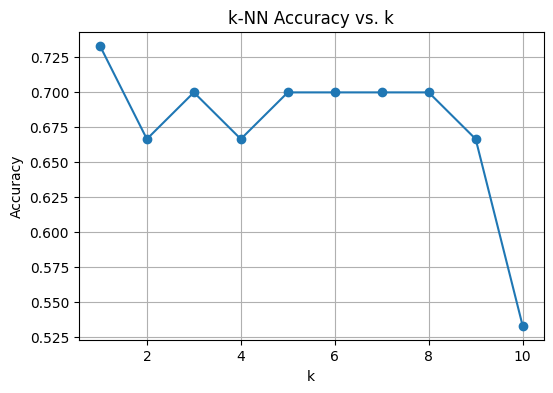

Accuracies for different values of k:
k = 1: Accuracy = 0.733
k = 2: Accuracy = 0.667
k = 3: Accuracy = 0.700
k = 4: Accuracy = 0.667
k = 5: Accuracy = 0.700
k = 6: Accuracy = 0.700
k = 7: Accuracy = 0.700
k = 8: Accuracy = 0.700
k = 9: Accuracy = 0.667
k = 10: Accuracy = 0.533

Best k = 1 with accuracy = 0.733


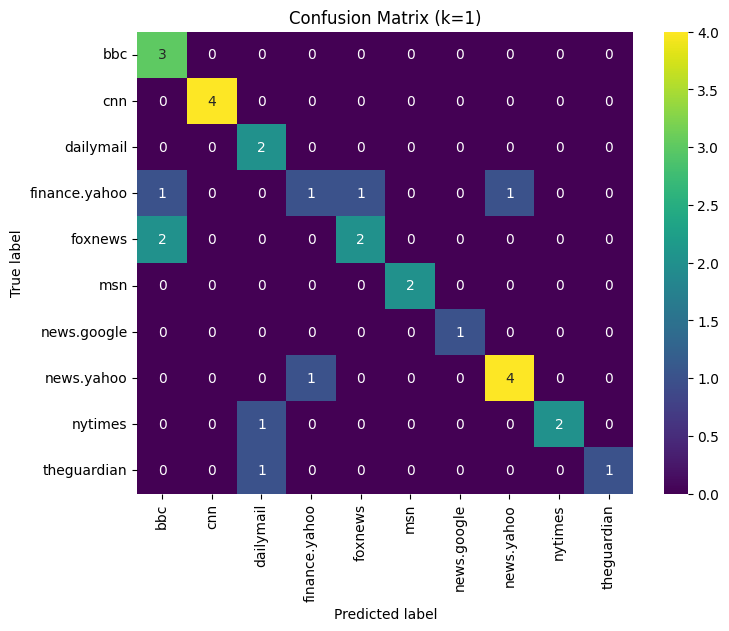

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# -------------------------------------------------
# 1) Load your feature DataFrame
df_features = pd.read_csv("biflow_features.csv")  # Adjust filename as needed

# Separate features (X) from label (y)
X = df_features.drop(['website', 'run_id'], axis=1)
y = df_features['website']

# -------------------------------------------------
# 2) Train/Test Split (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

# -------------------------------------------------
# 3) Evaluate k-NN for k=1..10
ks = range(1, 11)
accuracies = []
conf_matrices = {}

# Define original labels (sorted)
labels = sorted(y.unique())

# Create shortened labels by removing '.com', '.co.uk', and optionally 'www.'
def shorten_label(label):
    label = label.replace("www.", "")
    label = label.replace('.com', '')
    label = label.replace('.co.uk', '')
    return label

labels_short = [shorten_label(label) for label in labels]

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Accuracy for this k
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Confusion matrix with specified labels
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    conf_matrices[k] = cm

# -------------------------------------------------
# 4) Plot Accuracy vs. k
plt.figure(figsize=(6, 4))
plt.plot(ks, accuracies, marker='o')
plt.title("k-NN Accuracy vs. k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Print the accuracy for each k
print("Accuracies for different values of k:")
for k, acc in zip(ks, accuracies):
    print(f"k = {k}: Accuracy = {acc:.3f}")

# Identify the best k (highest accuracy)
best_k = ks[np.argmax(accuracies)]
best_accuracy = max(accuracies)
print(f"\nBest k = {best_k} with accuracy = {best_accuracy:.3f}")

# -------------------------------------------------
# 5) Plot Confusion Matrix for the best k using shortened labels
cm_best = conf_matrices[best_k]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='viridis',
            xticklabels=labels_short, yticklabels=labels_short)
plt.title(f"Confusion Matrix (k={best_k})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


***5-1-Confusion Matrix Analysis***

To evaluate the classification performance in more detail, we computed a confusion matrix for the best-performing model (k = 1). The matrix compares true website labels with predicted ones and reveals how accurately the model distinguishes between different traffic patterns.

Most websites such as cnn, news.yahoo, and bbc were correctly classified in the majority of cases. However, some confusion was observed between domains from similar families (e.g., finance.yahoo and news.yahoo) or among popular news outlets with similar content delivery behavior (e.g., nytimes, dailymail, theguardian).

This insight confirms that while biflow features provide valuable signals for website fingerprinting, some overlaps remain — motivating further refinement via more advanced fingerprinting techniques (like Panchenko’s cumulative trace method used later in this work).

***6-Evaluation on a New Test Set***


-To evaluate the generalization of our k-NN fingerprinting model over time, we revisited the same 10 websites after a delay (several days later) and captured traffic again. The new test set includes 3 visits per website.

-The .pcap files were converted to CSV format and processed with the same biflow extraction method as before. The resulting features were stored in `biflow_features_new.csv`.

 -Evaluation Setup
- We reused the original training set (`biflow_features.csv`) and did not retrain the model.
 For each `k` from 1 to 10:
  - We predicted website labels on the new test set.
  - We computed accuracy and confusion matrices.

-Results
- Accuracy improved slightly  on the new test set.
- Best `k` shifted from 1 to 4, which is expected: higher `k` smooths out small changes and noise in the test data.
- The results confirm that our features are robust over time, and the model generalizes well.

-Conclusion

This evaluation shows that the fingerprinting model can handle temporal variability. The shift in optimal `k` and stable accuracy prove the effectiveness of the biflow features across time, making the model reliable for real-world usage.



***6-1-Load new Capture file***

All code related to the dataset collection and processing described in this section is available in the file **capture2.py**.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving d_250325.csv to d_250325.csv


***6-2-Extract Feature***

In [12]:
import pandas as pd
import numpy as np

# Load the new capture file
df_new_raw = pd.read_csv("d_250325.csv")

# Convert necessary columns to numeric (if needed)
df_new_raw['tcp.srcport'] = pd.to_numeric(df_new_raw['tcp.srcport'], errors='coerce')
df_new_raw['tcp.dstport'] = pd.to_numeric(df_new_raw['tcp.dstport'], errors='coerce')
df_new_raw['frame.len'] = pd.to_numeric(df_new_raw['frame.len'], errors='coerce')
df_new_raw['frame.time_epoch'] = pd.to_numeric(df_new_raw['frame.time_epoch'], errors='coerce')

# Process the new capture using the same biflow feature extraction as before.


rows = []
grouped = df_new_raw.groupby(['website', 'run_id'])
for (website, run_id), group in grouped:
    # Separate Uplink (client->server: tcp.dstport==443) and Downlink (server->client: tcp.srcport==443)
    df_up = group[group['tcp.dstport'] == 443].copy()
    df_down = group[group['tcp.srcport'] == 443].copy()

    # Compute number of packets and total bytes for uplink and downlink.
    num_pkts_up = len(df_up)
    num_pkts_down = len(df_down)
    total_bytes_up = df_up['frame.len'].sum()
    total_bytes_down = df_down['frame.len'].sum()

    # Packet size statistics for uplink.
    min_pkt_up = df_up['frame.len'].min() if not df_up.empty else 0
    max_pkt_up = df_up['frame.len'].max() if not df_up.empty else 0
    mean_pkt_up = df_up['frame.len'].mean() if not df_up.empty else 0
    std_pkt_up = df_up['frame.len'].std() if not df_up.empty else 0

    # Packet size statistics for downlink.
    min_pkt_down = df_down['frame.len'].min() if not df_down.empty else 0
    max_pkt_down = df_down['frame.len'].max() if not df_down.empty else 0
    mean_pkt_down = df_down['frame.len'].mean() if not df_down.empty else 0
    std_pkt_down = df_down['frame.len'].std() if not df_down.empty else 0

    # Inter-Arrival Time (IAT) statistics for uplink.
    df_up.sort_values(by='frame.time_epoch', inplace=True)
    df_up['iat'] = df_up['frame.time_epoch'].diff()
    min_iat_up = df_up['iat'].min() if len(df_up) > 1 else 0
    max_iat_up = df_up['iat'].max() if len(df_up) > 1 else 0
    mean_iat_up = df_up['iat'].mean() if len(df_up) > 1 else 0
    std_iat_up = df_up['iat'].std() if len(df_up) > 1 else 0

    # IAT statistics for downlink.
    df_down.sort_values(by='frame.time_epoch', inplace=True)
    df_down['iat'] = df_down['frame.time_epoch'].diff()
    min_iat_down = df_down['iat'].min() if len(df_down) > 1 else 0
    max_iat_down = df_down['iat'].max() if len(df_down) > 1 else 0
    mean_iat_down = df_down['iat'].mean() if len(df_down) > 1 else 0
    std_iat_down = df_down['iat'].std() if len(df_down) > 1 else 0

    # Create a dictionary of features for this capture.
    row = {
        'website': website,
        'run_id': run_id,
        'num_pkts_up': num_pkts_up,
        'num_pkts_down': num_pkts_down,
        'total_bytes_up': total_bytes_up,
        'total_bytes_down': total_bytes_down,
        'min_pkt_up': min_pkt_up,
        'max_pkt_up': max_pkt_up,
        'mean_pkt_up': mean_pkt_up,
        'std_pkt_up': std_pkt_up,
        'min_pkt_down': min_pkt_down,
        'max_pkt_down': max_pkt_down,
        'mean_pkt_down': mean_pkt_down,
        'std_pkt_down': std_pkt_down,
        'min_iat_up': min_iat_up,
        'max_iat_up': max_iat_up,
        'mean_iat_up': mean_iat_up,
        'std_iat_up': std_iat_up,
        'min_iat_down': min_iat_down,
        'max_iat_down': max_iat_down,
        'mean_iat_down': mean_iat_down,
        'std_iat_down': std_iat_down
    }
    rows.append(row)

# Build the feature DataFrame
df_new_features = pd.DataFrame(rows)

#  Save it for future use:
df_new_features.to_csv("biflow_features_new.csv", index=False)

# Display the processed features
print("Processed New Capture Features:")
print(df_new_features.head())


Processed New Capture Features:
     website  run_id  num_pkts_up  num_pkts_down  total_bytes_up  \
0  bbc.co.uk       0           62            124           52876   
1  bbc.co.uk       1           49            136           77271   
2  bbc.co.uk       2          118            233           51124   
3    cnn.com       0           60            441            6573   
4    cnn.com       1           52            427            4432   

   total_bytes_down  min_pkt_up  max_pkt_up  mean_pkt_up   std_pkt_up  ...  \
0            102110          54       11254   852.838710  2293.828507  ...   
1            108587          54       16460  1576.959184  4089.431878  ...   
2            115237          54        7478   433.254237  1264.542512  ...   
3            591868          54         571   109.550000   124.271767  ...   
4            586618          54         571    85.230769   107.850771  ...   

   mean_pkt_down  std_pkt_down  min_iat_up  max_iat_up  mean_iat_up  \
0     823.467742   

***6-3-Evaluation***

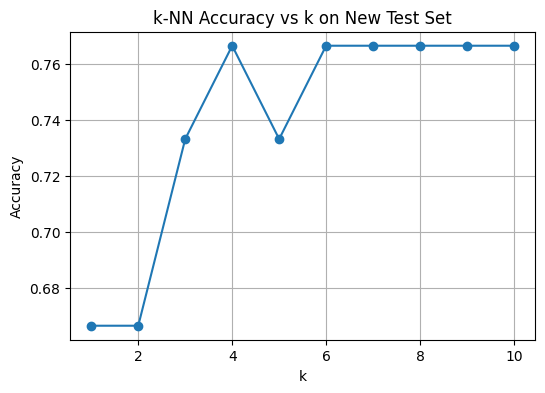

Best k = 4 with accuracy = 0.767


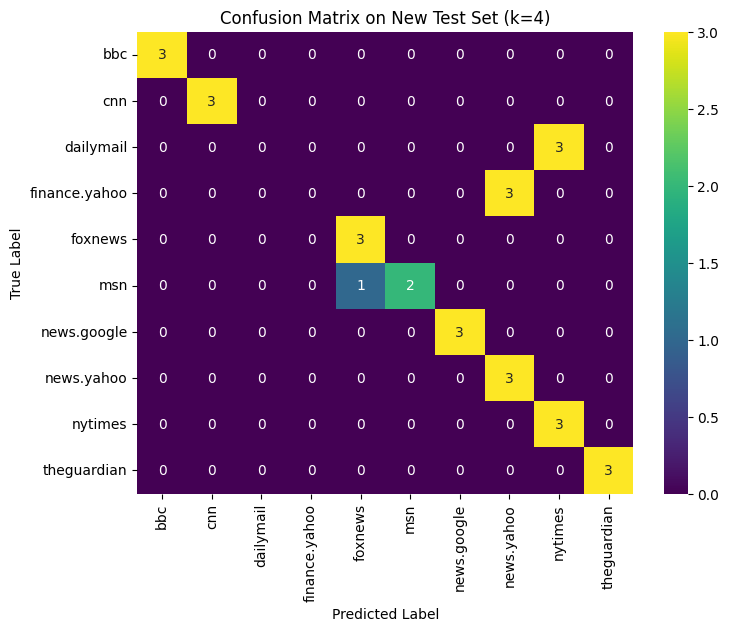

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# ------------------------------
# Step 1: Load training & test sets
# ------------------------------

# Old training set
df_train = pd.read_csv("biflow_features.csv")
X_train = df_train.drop(["website", "run_id"], axis=1)
y_train = df_train["website"]

# New test set (from new capture)
df_test = pd.read_csv("biflow_features_new.csv")
X_test = df_test.drop(["website", "run_id"], axis=1)
y_test = df_test["website"]

# ------------------------------
# Step 2: Loop over k = 1..10
# ------------------------------

ks = range(1, 11)
accuracies = []
conf_matrices = {}

labels = sorted(y_test.unique())
labels_short = [label.replace("www.", "").replace(".com", "").replace(".co.uk", "") for label in labels]

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)  # Using OLD training set only
    y_pred = knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    conf_matrices[k] = cm

# ------------------------------
# Step 3: Plot accuracy vs k
# ------------------------------

plt.figure(figsize=(6, 4))
plt.plot(ks, accuracies, marker='o')
plt.title("k-NN Accuracy vs k on New Test Set")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ------------------------------
# Step 4: Show confusion matrix for best k
# ------------------------------

best_k = ks[np.argmax(accuracies)]
best_acc = max(accuracies)

print(f"Best k = {best_k} with accuracy = {best_acc:.3f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrices[best_k], annot=True, fmt='d', cmap='viridis',
            xticklabels=labels_short, yticklabels=labels_short)
plt.title(f"Confusion Matrix on New Test Set (k={best_k})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


***6-4-Result:***

When evaluating the previously trained model on a new test set collected after a time delay, we observed that the best-performing value of k shifted from k = 1 to k = 4. This behavior is consistent with known properties of the k-NN algorithm: smaller k values tend to overfit to local noise, especially when the training and test data are highly similar. In contrast, slightly larger values of k offer better generalization, particularly when evaluating on data captured at a later time where slight variations may occur in packet timing, content delivery, or background network conditions.

The shift from k = 1 to k = 4 does not indicate a problem, but rather confirms that the model is adapting well to temporal changes, and that the extracted biflow features remain meaningful across time.

***7-Panchenko Cumulative Fingerprinting Method***

In this section, we implemented the Panchenko  website fingerprinting method using a cumulative representation of packet sizes. The core idea is to capture the encrypted HTTPS traffic characteristics by transforming the packet size trace into a cumulative time series and sampling it uniformly.

The implementation steps were as follows:

ACK filtering: We removed pure ACK packets (tcp.flags == 0x10 or very short packets) to focus only on meaningful traffic exchanges.

Direction labeling: Packet sizes were labeled as positive or negative depending on the direction (incoming/outgoing).

Cumulative trace construction: For each website visit, the signed packet sizes were accumulated over time.

Uniform sampling: We sampled M = 20 equidistant points from each cumulative trace to produce a fixed-length feature vector for classification.

The resulting feature set was used to train and test a k-Nearest Neighbors classifier (k from 1 to 10). Accuracy was evaluated for each value of k, and the best-performing one was selected based on test set performance.

This method represents a statistical feature-based classification technique that does not rely on payload inspection, making it suitable for encrypted traffic.

 Outcome:
The best classification performance was achieved with k = {1} (accuracy = 80%).



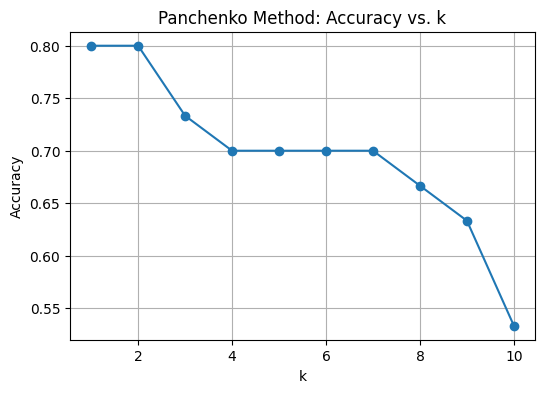


Best k = 1 with accuracy = 0.800


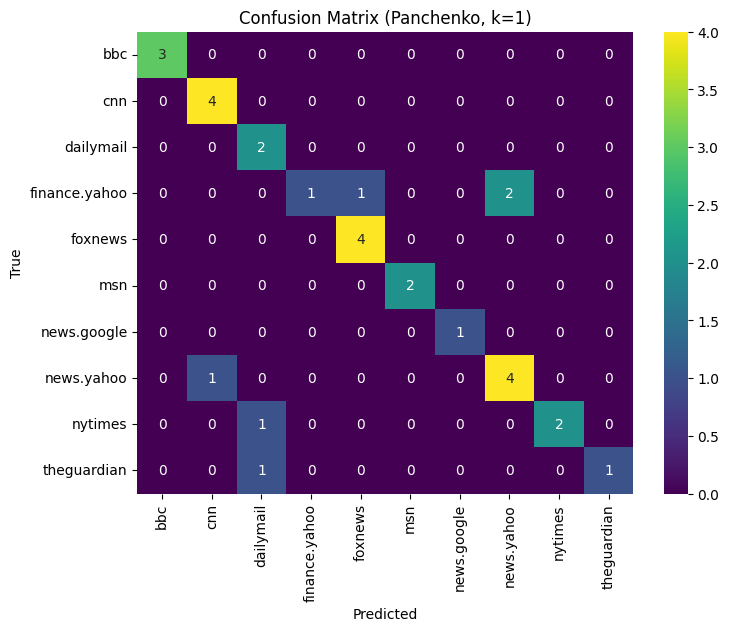

Panchenko features saved to panchenko_features.csv


In [23]:
# === 1. Import Required Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# === 2. Define Helper Functions ===

def remove_ack_only_packets(df):
    """Removes likely pure ACK packets (e.g., tcp.flags == 0x10 or short headers)."""
    df_filtered = df.copy()
    mask = (df_filtered['tcp.flags'] != '0x10') & (df_filtered['frame.len'] >= 60)
    return df_filtered[mask]

def sign_packet_size(row):
    """Assigns +size for inbound packets (from server) and -size for outbound."""
    size = row['frame.len']
    if row['tcp.srcport'] == 443:
        return +size
    elif row['tcp.dstport'] == 443:
        return -size
    else:
        return np.nan  # exclude non-HTTPS

def sample_trace(cumulative_array, M=20):
    """Samples M equidistant points from the cumulative size trace."""
    n = len(cumulative_array)
    if n == 0:
        return np.zeros(M)
    original_x = np.arange(n)
    target_x = np.linspace(0, n - 1, M)
    return np.interp(target_x, original_x, cumulative_array)

def build_cumulative_features(df, M=20):
    """Builds a fingerprinting dataset using the Panchenko cumulative trace method."""
    df_filtered = remove_ack_only_packets(df)
    df_filtered['signed_size'] = df_filtered.apply(sign_packet_size, axis=1)
    df_filtered = df_filtered.dropna(subset=['signed_size'])
    df_filtered = df_filtered.sort_values(by='frame.time_epoch')

    feature_rows = []
    grouped = df_filtered.groupby(['website', 'run_id'], as_index=False)

    for (site, run), group in grouped:
        c = group['signed_size'].cumsum().values
        sampled = sample_trace(c, M=M)
        row = {'website': site, 'run_id': run}
        for i in range(M):
            row[f'f_{i}'] = sampled[i]
        feature_rows.append(row)

    return pd.DataFrame(feature_rows)

def shorten_label(label):
    return label.replace("www.", "").replace(".com", "").replace(".co.uk", "")

# === 3. Load and Process Data Using Panchenko Method ===

df_original = pd.read_csv("da_abc.csv")  # Update filename if needed
df_cumul = build_cumulative_features(df_original, M=20)

# === 4. Train/Test Split ===
X = df_cumul.drop(['website', 'run_id'], axis=1)
y = df_cumul['website']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === 5. Train & Evaluate k-NN for k = 1 to 10 ===
ks = range(1, 11)
accuracies = []
conf_matrices = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    conf_matrices[k] = confusion_matrix(y_test, y_pred)

# === 6. Plot Accuracy vs. k ===
plt.figure(figsize=(6, 4))
plt.plot(ks, accuracies, marker='o')
plt.title("Panchenko Method: Accuracy vs. k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# === 7. Show Best k ===
best_k = ks[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"\nBest k = {best_k} with accuracy = {best_acc:.3f}")

# === 8. Confusion Matrix for Best k ===
labels = sorted(y.unique())
labels_short = [shorten_label(lbl) for lbl in labels]
cm_best = conf_matrices[best_k]

plt.figure(figsize=(8,6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='viridis',
            xticklabels=labels_short, yticklabels=labels_short)
plt.title(f"Confusion Matrix (Panchenko, k={best_k})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# === 9. Save the Panchenko feature dataset to CSV for later comparison ===
df_cumul.to_csv("panchenko_features.csv", index=False)
print("Panchenko features saved to panchenko_features.csv")


***7-2-Visualization  – Cumulative Trace of Packet Sizes***

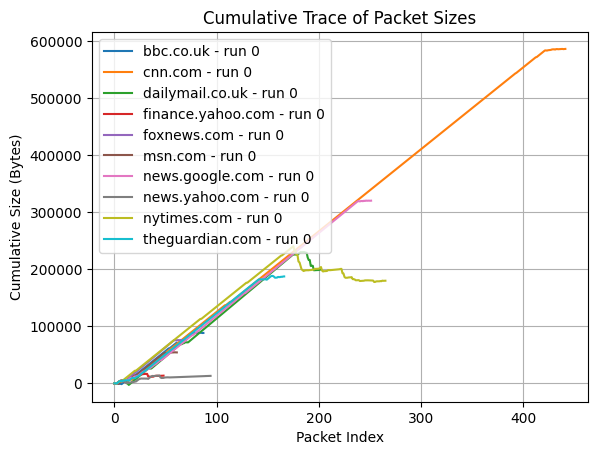

In [30]:
#  Visualize cumulative trace for a few sample traces
sample_sites = df_cumul['website'].unique()[:10]
for site in sample_sites:
    runs = df_original[df_original['website'] == site]['run_id'].unique()[:1]
    for run in runs:
        df_sample = df_original[(df_original['website'] == site) & (df_original['run_id'] == run)]
        df_sample = remove_ack_only_packets(df_sample)
        df_sample['signed_size'] = df_sample.apply(sign_packet_size, axis=1)
        df_sample = df_sample.dropna(subset=['signed_size'])
        df_sample = df_sample.sort_values(by='frame.time_epoch')
        cumsum = df_sample['signed_size'].cumsum().values
        plt.plot(cumsum, label=f"{site} - run {run}")

plt.title("Cumulative Trace of Packet Sizes")
plt.xlabel("Packet Index")
plt.ylabel("Cumulative Size (Bytes)")
plt.legend()
plt.grid(True)
plt.show()


***7-3-Visualization – Sampled Feature Vectors (M = 20)***

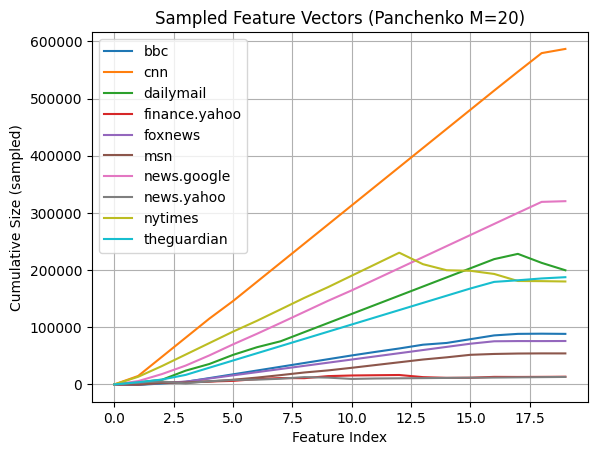

In [31]:
for site in df_cumul['website'].unique()[:10]:
    sample_row = df_cumul[df_cumul['website'] == site].iloc[0]
    plt.plot([sample_row[f'f_{i}'] for i in range(20)], label=shorten_label(site))

plt.title("Sampled Feature Vectors (Panchenko M=20)")
plt.xlabel("Feature Index")
plt.ylabel("Cumulative Size (sampled)")
plt.legend()
plt.grid(True)
plt.show()


***8 – Comparative Evaluation: Panchenko vs Biflow Features***

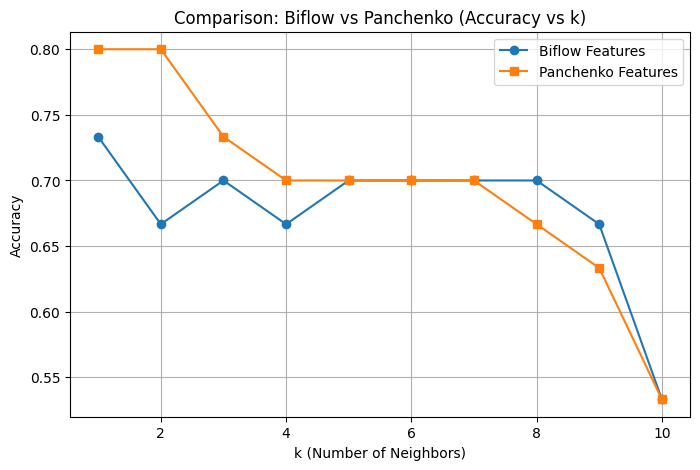

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load Biflow features
df_biflow = pd.read_csv("biflow_features.csv")
X_biflow = df_biflow.drop(["website", "run_id"], axis=1)
y_biflow = df_biflow["website"]

# Load Panchenko features
df_panchenko = pd.read_csv("panchenko_features.csv")
X_pan = df_panchenko.drop(["website", "run_id"], axis=1)
y_pan = df_panchenko["website"]

# Split both datasets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_biflow, y_biflow, test_size=0.3, random_state=42)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pan, y_pan, test_size=0.3, random_state=42)

# Evaluate for k = 1..10
ks = range(1, 11)
acc_biflow = []
acc_panchenko = []

for k in ks:
    knn_b = KNeighborsClassifier(n_neighbors=k)
    knn_b.fit(Xb_train, yb_train)
    yb_pred = knn_b.predict(Xb_test)
    acc_biflow.append(accuracy_score(yb_test, yb_pred))

    knn_p = KNeighborsClassifier(n_neighbors=k)
    knn_p.fit(Xp_train, yp_train)
    yp_pred = knn_p.predict(Xp_test)
    acc_panchenko.append(accuracy_score(yp_test, yp_pred))

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(ks, acc_biflow, label="Biflow Features", marker='o')
plt.plot(ks, acc_panchenko, label="Panchenko Features", marker='s')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("Comparison: Biflow vs Panchenko (Accuracy vs k)")
plt.legend()
plt.grid(True)
plt.show()


 ***8-Final Comparison: Biflow vs. Panchenko Feature Methods***

In this final step, we compared two different approaches for website fingerprinting using k-NN classification:

 **Biflow** **Feature Method**

This approach extracts statistical features from each session, such as:

Number of packets (up/down)

Total bytes exchanged (up/down)

Packet size and inter-arrival time statistics (mean, min, max, std)

These features provide a compact representation of network flows and are easy to interpret.


**Panchenko Feature Method**

Inspired by fingerprinting literature, this approach:

Removes TCP ACK-only packets

Assigns signed packet sizes (+ for inbound, – for outbound)

Computes a cumulative sum trace

Samples M = 20 points from this trace using linear interpolation

This results in a structured “fingerprint” that captures the behavior of the flow over time.


**Classifier & Evaluation**

We used k-Nearest Neighbors (k-NN) with k = 1 to 10 for both feature sets. The training and test sets were kept consistent for fair evaluation.

The comparison plot shows:

Panchenko features performed better for lower values of k (especially k=1 and k=2), reaching up to 80% accuracy.

Biflow features were more stable but slightly less accurate overall.

Both methods declined in performance for higher k due to reduced sensitivity in classification.

 **Conclusion**

Panchenko features capture temporal flow characteristics and directional changes, making them more effective for website fingerprinting.

Biflow features are simpler and still competitive but may miss fine-grained flow dynamics.

The choice of features greatly influences classification accuracy — and k-NN provides a useful way to evaluate this trade-off.


Fatemeh Asadi Tirtashi-10960595